Fitting in python

J.A. Koch 16 Dec 2019

This notebook contains code examples for fitting data, some with complicated implementations. Included are fits to:
1. a functional model
2. a two-state functional model with two separate data sets
3. a first-order ODE model
4. a second-order ODE model
5. an integral model

We import the essential modules in the first cell -- borrow things from this document, make sure you include the relevant imports.

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline

# Fit a function:

Given data $(x,y)$, fit a curve $y=f(x)$. Here we use $y=c x^m$ for parameters $m$ and $c$.

For c*x^m:
m= -0.184 , c= 1.503


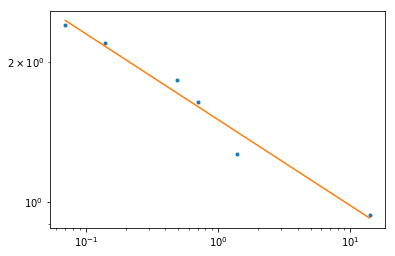

In [11]:
# some data
x=np.array([0.07,0.14,0.49,0.7,1.4,14])
y=np.array([2.39827,2.19523,1.82498,1.63926,1.26901,0.93757])

# function
def pwrlaw(x,m,c): #independent variable x, two parameters m & c
    return c*x**m

# curve_fit fits an (x,y) data set to a function
powV, _ = curve_fit(pwrlaw, x, y) # fitted parameters stored as array powV
# we ignore the second output of this command (which is something like the error) by using _
m=powV[0]
c=powV[1]


print("For c*x^m:")
print("m=",m.round(decimals=3),", c=",c.round(decimals=3))
# plotting
plt.loglog(x,y,'.')
plt.loglog(x,pwrlaw(x,powV[0],powV[1]))
plt.show()

# Simultaneous fit for model with two states:

Given two data sets $(x_1,y_1)$ and $(x_2,y_2)$, fit $y_1=f(x_1)$ and $y_2=g(x_2)$, where parameters are shared between $f$ and $g$. Here we use a rheological model with two states and four parameters:

* with no vibration: $\tau = G \gamma_\text{c} + \eta_\text{H} \dot{\gamma}.\quad\quad$ 
* with vibration: $\tau = \gamma_\text{c}\frac{G+\eta_\text{H}~f_\text{B}}{\dot{\gamma}+\gamma_\text{c}~f_\text{B}}\dot{\gamma}+\frac{\eta_\text{H}}{\dot{\gamma}+\gamma_\text{c}~f_\text{B}}\dot{\gamma}^2$




For a simultaneous fit, we must stitch together the two data sets and create different fitting targets for each half of the 
data.


(I encountered this model in my dissertation. _Hanotin, C., et al. "Viscoelasticity of vibrated granular suspensions." Journal of rheology (2015)._)

G= 1496.528 , gamma_c= 0.137 , eta_H= 9.792 , f_B= 0.39


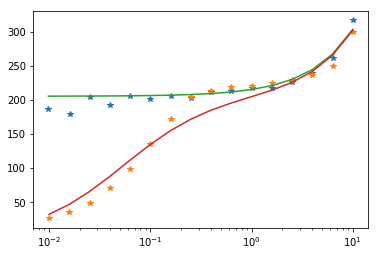

In [12]:
# some data
x_v=np.array([9.99991,6.30959,3.98105,2.51174,1.58487,0.99994,0.63104,0.39806,0.25115,0.15849,0.09999,0.0631,0.0398,0.02512,0.01585,0.01])
y_v=np.array([300.297,250.444,237.17,229.641,224.519,220.818,218.62,213.132,204.573,172.079,135.38,99.5142,71.0392,49.0162,35.9663,26.9438])
x_u=np.array([10.0002,6.30945,3.98143,2.51179,1.58505,0.99994,0.63107,0.3981,0.25121,0.15851,0.09994,0.06301,0.03992,0.02517,0.016,0.00986])
y_u=np.array([316.604,260.901,239.982,226.806,218.124,216.893,212.678,211.504,203.419,206.058,201.123,205.835,192.87,204.989,179.441,187.024])

# functions for TWO states: unvibrated...
def u(x,G,g,n,f): # independent variable x and four parameters
    return G*g+n*x
# ...and vibrated
def v(x,G,g,n,f):
    return g*(G+n*f)/(x+g*f)*x+n/(x+g*f)*x**2

# Here, the data is not fit to a single function. We must instead use 
# stitch into single residual function
def res_two_fxns(pars,xv_a,yv_a,xu_a,yu_a):
    G=pars[0] # G
    gc=pars[1] # \gamma_\text{c}
    nH=pars[2] # \eta_\text{H}
    fB=pars[3] # f_\text{B}

    #vib data
    diff_v=yv_a-v(xv_a,G,gc,nH,fB)
    #unv data
    diff_u=yu_a-u(xu_a,G,gc,nH,fB)

    return np.append(diff_v,diff_u)

# initial guess for parameters
par_init=np.array([1000.,.2,10.,1.])

# fit occurs through least_squares
result=least_squares(res_two_fxns,par_init,args=(x_v,y_v,x_u,y_u),bounds=(0, np.inf))


G=result.x[0]
gc=result.x[1]
nH=result.x[2]
fB=result.x[3]

print("G=",G.round(decimals=3),", gamma_c=",gc.round(decimals=3),", eta_H=",nH.round(decimals=3),", f_B=",fB.round(decimals=3))

# plotting
plt.semilogx(x_u,y_u,'*')
plt.semilogx(x_v,y_v,'*')
plt.semilogx(x_u,u(x_u,G,gc,nH,fB),'-')
plt.semilogx(x_v,v(x_v,G,gc,nH,fB),'-')
plt.show()

# Fit an ODE model:

Given data $(t,x)$, fit a first-order ODE: $x'=f(x,t)$. Here we look at a Maxwell Material (spring and damper in series), $\dot{\epsilon} = \frac{1}{E}\dot{\sigma}+\frac{1}{\eta}\sigma$, with an instantaneous step to constant strain. The stress therefore will demonstrate an exponential response. We can fit with the algebraic analytical solution but will instead demonstrate with an ODE fit, including with a fit to the initial condition.

Further, we demonstrate how to include a parameter that WILL NOT be fit. Using python's lambda functions we describe which parameters are variable, and include a dummy variable which will remain to whatever it is initially assigned to.

In [5]:
# some data

t_data=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])
y_data=np.array([15.88727844,11.04127365,6.845958057,5.232227909,4.00281566,2.643838687,1.790789713,1.402592203,1.060416803,0.683737715,0.520579602,0.340215872,0.277701085,0.170467257,0.126545076,0.097850084,0.06003357,0.042464386,0.03522112,0.024377014,0.015634876])

y0= 15.724 , E= 2.858 , eta= 0.785
time constant= 0.275


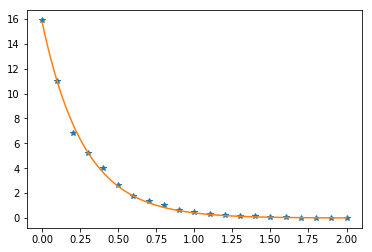

In [6]:
Q=150. # dummy variable

def s_dot(y,t,E,eta,Q):
    return -E/eta * y + 0.0*Q

def s(t,y0,E,eta,Q):
    y_fit=odeint(s_dot, y0, t, args=(E,eta,Q))
    return y_fit[:,0]

par,popt=curve_fit(lambda t,y0,E,eta: s(t,y0,E,eta,Q),t_data,y_data,bounds=(0, np.inf))
# The lambda function here works with the independent variable t and three parameters y0, E, and eta.
# The additional parameter Q is defined as part of the function definitions for s & s_dot, but will not be fit.

y0=par[0]
E=par[1]
eta=par[2]
# Q=par[3] # uncomment and it will throw an error! The fit only performed on y0, E, and eta.
print("y0=",y0.round(decimals=3),", E=",E.round(decimals=3),", eta=",eta.round(decimals=3))
print("time constant=",(eta/E).round(decimals=3))

# plotting
t_fit=np.linspace(0,max(t_data),100)
plt.plot(t_data,y_data,'*')
plt.plot(t_fit,s(t_fit,y0,E,eta,Q),'-')
plt.show()


## Second order ODE:

Use $\ddot{x}+2\zeta \omega_0 \dot{x} + \omega_0^2 x = 0$


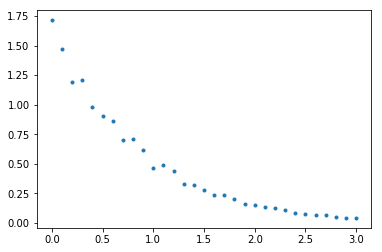

In [70]:
# some data
t_data=np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0])
y_data=np.array([1.713857512,1.473823354,1.189254362,1.208155536,0.980638928,0.901433353,0.86148005,0.703975981,0.70552957,0.614729416,0.462508395,0.492432239,0.441391405,0.330731011,0.319606025,0.280996331,0.231736065,0.238614261,0.205168077,0.162675796,0.148077374,0.134986682,0.126656308,0.107827756,0.086489102,0.073737365,0.067371589,0.064494914,0.051101813,0.042038031,0.042966735])

plt.plot(t_data,y_data,'.')
plt.show()

In [ ]:
def ODE2(y,t,z,w0):
    yp,y = Y
    ypp = -2*z*w0*yp- w0**2*y
    return ypp

def s(t,Y0,z,w0):
    Y0=yp0,y0
    y_fit=odeint(ODE2, Y0, t, args=(z,w0))
    return y_fit[:,0]

par,popt=curve_fit(lambda t,y0,E,eta: s(t,y0,E,eta,Q),t_data,y_data,bounds=(0, np.inf))
# The lambda function here works with the independent variable t and three parameters y0,E, and eta.
# The additional parameter Q is defined as part of the function definitions for s & s_dot, but will not be fit.

y0=par[0]
E=par[1]
eta=par[2]
# Q=par[3] # uncomment and it will throw an error! The fit only performed on the initial condition y0, E, and eta 
print("y0=",y0.round(decimals=3),", E=",E.round(decimals=3),", eta=",eta.round(decimals=3))
print("time constant=",(eta/E).round(decimals=3))

# plotting
t_fit=np.linspace(0,max(t_data),100)
plt.plot(t_data,y_data,'*')
plt.plot(t_fit,s(t_fit,y0,E,eta,Q),'-')
plt.show()

In [ ]:
par,popt=curve_fit(lambda t,R_s: g(t,x0,R_s,W[n]),t_data[idx:]-t_data[idx],x_data[idx:],bounds=(0, .5))

# Model with integral

Given data $(x_1,y_1)$ and $(x_2,y_2)$, fit $y_1=\int_{a}^{b}H_1(x_1,t)dt$ and $y_2=\int_{c}^{d}H_2(x_2,t)dt$, where parameters are shared between $H_1$ and $H_2$. Here we fit $G'(\omega)$ and $G''(\omega)$ data to a continuous Maxwell model with
three fitting parameters: $(A,\sigma,\tau)$, here denoted (a,b,c). The model (I believe from Tschoegl) looks like:

* $G'(\omega) = \int_{0}^{\infty} A\exp\left[\frac{-1}{2\sigma^2}\left[\log(t)-\log(\tau)\right]^2\right]\frac{\omega^2t}{1+(\omega t)^2} dt$
* $G''(\omega) = \int_{0}^{\infty} A\exp\left[\frac{-1}{2 \sigma^2}\left[\log(t)-\log(\tau)\right]^2\right]\frac{\omega t}{1+(\omega t)^2} dt$

We numerically integrate using integrate.quad and again define a new residual function to fit over two data sets.


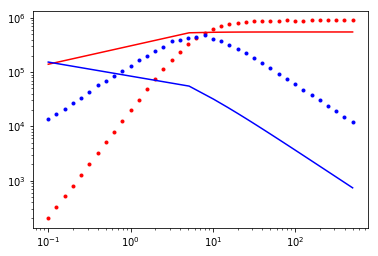

A= 111982.0 , sigma= 1.307 , tau= 0.64


In [21]:
from scipy import integrate
from scipy.optimize import least_squares

# some data: oscillation frequency, G', and G''
x=np.array([0.1,0.12589,0.15849,0.19953,0.25119,0.31623,0.39811,0.50119,0.63096,0.79433,1,1.25892,1.5849,1.99526,2.51189,3.16229,3.98105,5.01186,6.30957,7.94327,10.0001,12.5892,15.849,19.9526,25.1188,31.623,39.8105,50.119,63.0957,79.4327,100,125.892,158.488,199.525,251.188,316.226,398.105,499.995])
y1=np.array([202.45445,320.81352,508.37405,805.47595,1275.89108,2020.48246,3198.0499,5058.03912,7990.16625,12598.09289,19904.40098,30988.75859,48145.07709,73989.0287,111985.3337,165307.1756,236575.3079,329983.2014,425251.392,528045.3188,623080.7574,702890.0275,764698.1352,809614.874,840775.7101,891702.6457,875449.8863,884352.743,890063.3753,899704.7512,896017.6991,897483.2067,898410.3575,898996.3535,899366.4857,899600.1732,899747.6851,899840.0252])
y2=np.array([13496.96318,16989.09192,21084.06417,26912.44251,33862.57634,42595.20942,58553.87365,67280.39421,84423.37871,105733.4935,132029.3399,164102.3448,202585.7301,247215.9976,296948.6024,378496.7658,396169.0306,432285.5539,449318.9362,493180.4691,415383.0177,372218.5299,321659.8882,270512.7399,223146.464,181661.5851,146602.8454,117633.7308,94043.74364,75007.29139,59734.51327,47526.62106,37790.8888,30037.88509,23869.67758,18965.34279,15067.1755,11997.98698])

# preallocate space for fitting data
f_int1 = np.zeros(len(x))
f_int2 = np.zeros(len(x))

def H1(t,x,a,b,c): # integrand1, for dummy variable t, x, and three parameters A, sigma, tau
    return a*np.exp(-1/(2*b**2)*(np.log(t)-np.log(c))**2)*x**2*t**2/(1+(x*t)**2)

def H2(t,x,a,b,c): # integrand2
    return a*np.exp(-1/(2*b**2)*(np.log(t)-np.log(c))**2)*x*t/(1+(x*t)**2)

def F1(x,a,b,c): # integral1
    for i in np.arange(len(x)):
        f_int1[i] = (integrate.quad(H1,0.,np.inf,args=(x[i],a,b,c)))[0]
        # integrate.quad returns two things: the value, and the error tolerance.
        # [0] takes the first of those.
    return f_int1

def F2(x,a,b,c): # integral2
    for i in np.arange(len(x)):
        f_int2[i] = (integrate.quad(H2,0.,np.inf,args=(x[i],a,b,c)))[0]
    return f_int2
    # Running through for loops is very slow, but integrate.quad does
    # not accept vector arguments. The data set is hopefully small
    # so that not too much time is wasted in F1 and F2.

def res_two_fxns(pars,x_data,y1_data,y2_data):
    # pars are the parameters that are to be optimized. 
    # This function calculates residuals.
    a=pars[0]
    b=pars[1]
    c=pars[2]
    diff1=y1_data-F1(x_data,a,b,c)
    diff2=y2_data-F2(x_data,a,b,c)
    return np.append(diff1,diff2) 
    # An array of differences between fit and data at each data point.
    # This is the residuals function that the least squares routine is
    # trying to minimize.


# initial guess for parameters
par_init=np.array([100000.,.2,10.]) # [a,b,c]

result=least_squares(res_two_fxns,par_init,args=(x,y1,y2),bounds=(0, np.inf))

# best fits
a_fit=result.x[0]
b_fit=result.x[1]
c_fit=result.x[2]


#####################
# plot fit equations
def F_fit1(x,a,b,c): # integral1
    f_int_fit1 = np.zeros(len(x))
    for i in np.arange(len(x)):
        f_int_fit1[i] = (integrate.quad(H1,0.,np.inf,args=(x[i],a,b,c)))[0]
    return f_int_fit1

def F_fit2(x,a,b,c): # integral2
    f_int_fit2 = np.zeros(len(x))
    for i in np.arange(len(x)):
        f_int_fit2[i] = (integrate.quad(H2,0.,np.inf,args=(x[i],a,b,c)))[0]
    return f_int_fit2
# Copied from the above F1,F2,functions verbatim. The array size of the
# fit is larger than the array size of the data, so in order to avoid
# reallocating space for every iteration and for the final fit, I
# defined another instance of these functions. There might be a better
# way to do this.

x_fit=np.linspace(min(x), max(x),100)

y1_fit=np.zeros(len(x_fit))
y2_fit=np.zeros(len(x_fit))
y1_fit=F_fit1(x_fit,a_fit,b_fit,c_fit)
y2_fit=F_fit2(x_fit,a_fit,b_fit,c_fit)


# fig=plt.figure()
# ax1=fig.add_subplot(211)
# ax1.loglog(x,y1,'.',x_fit,y1_fit,'-')
# ax2=fig.add_subplot(212)
# ax2.loglog(x,y2,'.',x_fit,y2_fit,'-')
# plt.show()

plt.loglog(x,y1,'r.',x_fit,y1_fit,'r-')
plt.loglog(x,y2,'b.',x_fit,y2_fit,'b-')
plt.show()




print("A=",a_fit.round(decimals=0),", sigma=",b_fit.round(decimals=3),", tau=",c_fit.round(decimals=3))

# Additional notes

1. Uploading data: I usually used csv files because they consistently worked in the same way, you might have success with other upload methods.
~~~~
data = np.loadtxt(open("speed_data.csv"),delimiter=',',dtype=np.float)
x=data[:,0]
y=data[:,1]
~~~~
2. Piecewise functions: Probably easiest to define using python lambda functions.
~~~~
def Fx(x,T,Ec,n):
    y = np.piecewise(x, [x < Ec, x >= Ec], [lambda x:0, lambda x:1./T*((x/Ec)**2.-1.)**n])
    return y
~~~~
Here, the function returns "0" until x reaches a critical value Ec, which is also a parameter in the problem.
3. 